# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [30]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
learning_rates = [7e-7, 1e-6, 4e-6, 1e-5, 5e-5, 1e-4, 4e-4]
regularization_strengths = [1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 8e2, 1e3, 2e3, 3e3, 6e3, 8e3]
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=1200, verbose=True) 
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        valid_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, valid_accuracy)
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1200: loss 9.009856
iteration 100 / 1200: loss 8.996465
iteration 200 / 1200: loss 8.988713
iteration 300 / 1200: loss 8.997509
iteration 400 / 1200: loss 8.998103
iteration 500 / 1200: loss 8.975590
iteration 600 / 1200: loss 8.975020
iteration 700 / 1200: loss 8.978419
iteration 800 / 1200: loss 8.968206
iteration 900 / 1200: loss 8.953624
iteration 1000 / 1200: loss 8.965460
iteration 1100 / 1200: loss 8.953451
iteration 0 / 1200: loss 9.019522
iteration 100 / 1200: loss 9.012131
iteration 200 / 1200: loss 9.018266
iteration 300 / 1200: loss 9.007059
iteration 400 / 1200: loss 8.992918
iteration 500 / 1200: loss 8.980218
iteration 600 / 1200: loss 8.995744
iteration 700 / 1200: loss 8.992370
iteration 800 / 1200: loss 8.966535
iteration 900 / 1200: loss 8.988399
iteration 1000 / 1200: loss 8.969699
iteration 1100 / 1200: loss 8.951731
iteration 0 / 1200: loss 9.016297
iteration 100 / 1200: loss 9.002228
iteration 200 / 1200: loss 9.005954
iteration 300 / 1200: loss 8.9

iteration 0 / 1200: loss 9.066470
iteration 100 / 1200: loss 9.054147
iteration 200 / 1200: loss 9.061750
iteration 300 / 1200: loss 9.067303
iteration 400 / 1200: loss 9.027358
iteration 500 / 1200: loss 9.037220
iteration 600 / 1200: loss 9.039053
iteration 700 / 1200: loss 9.018335
iteration 800 / 1200: loss 9.024325
iteration 900 / 1200: loss 9.005974
iteration 1000 / 1200: loss 9.011203
iteration 1100 / 1200: loss 8.986915
iteration 0 / 1200: loss 9.135010
iteration 100 / 1200: loss 9.112651
iteration 200 / 1200: loss 9.105627
iteration 300 / 1200: loss 9.078894
iteration 400 / 1200: loss 9.091488
iteration 500 / 1200: loss 9.085208
iteration 600 / 1200: loss 9.074303
iteration 700 / 1200: loss 9.062805
iteration 800 / 1200: loss 9.058025
iteration 900 / 1200: loss 9.047248
iteration 1000 / 1200: loss 9.025107
iteration 1100 / 1200: loss 9.022134
iteration 0 / 1200: loss 9.781787
iteration 100 / 1200: loss 9.640022
iteration 200 / 1200: loss 9.513432
iteration 300 / 1200: loss 9.4

iteration 0 / 1200: loss 12.128699
iteration 100 / 1200: loss 9.115766
iteration 200 / 1200: loss 8.994638
iteration 300 / 1200: loss 8.991911
iteration 400 / 1200: loss 8.991542
iteration 500 / 1200: loss 8.990164
iteration 600 / 1200: loss 8.993048
iteration 700 / 1200: loss 8.989536
iteration 800 / 1200: loss 8.991792
iteration 900 / 1200: loss 8.990171
iteration 1000 / 1200: loss 8.993407
iteration 1100 / 1200: loss 8.991886
iteration 0 / 1200: loss 13.544875
iteration 100 / 1200: loss 9.029031
iteration 200 / 1200: loss 8.994148
iteration 300 / 1200: loss 8.995027
iteration 400 / 1200: loss 8.994413
iteration 500 / 1200: loss 8.993622
iteration 600 / 1200: loss 8.994836
iteration 700 / 1200: loss 8.994789
iteration 800 / 1200: loss 8.993847
iteration 900 / 1200: loss 8.993705
iteration 1000 / 1200: loss 8.994881
iteration 1100 / 1200: loss 8.994537
iteration 0 / 1200: loss 18.463509
iteration 100 / 1200: loss 8.997113
iteration 200 / 1200: loss 8.996423
iteration 300 / 1200: loss 

iteration 0 / 1200: loss 9.004445
iteration 100 / 1200: loss 8.615258
iteration 200 / 1200: loss 8.313139
iteration 300 / 1200: loss 8.043611
iteration 400 / 1200: loss 7.558404
iteration 500 / 1200: loss 7.347636
iteration 600 / 1200: loss 7.046800
iteration 700 / 1200: loss 6.814276
iteration 800 / 1200: loss 6.515782
iteration 900 / 1200: loss 6.387170
iteration 1000 / 1200: loss 5.684894
iteration 1100 / 1200: loss 5.586578
iteration 0 / 1200: loss 9.009925
iteration 100 / 1200: loss 8.663472
iteration 200 / 1200: loss 8.307199
iteration 300 / 1200: loss 7.885482
iteration 400 / 1200: loss 7.833205
iteration 500 / 1200: loss 7.308138
iteration 600 / 1200: loss 6.976154
iteration 700 / 1200: loss 6.717845
iteration 800 / 1200: loss 6.652003
iteration 900 / 1200: loss 6.623789
iteration 1000 / 1200: loss 6.262187
iteration 1100 / 1200: loss 6.290803
iteration 0 / 1200: loss 9.011549
iteration 100 / 1200: loss 8.702657
iteration 200 / 1200: loss 8.446721
iteration 300 / 1200: loss 8.1

iteration 0 / 1200: loss 9.155426
iteration 100 / 1200: loss 8.854066
iteration 200 / 1200: loss 8.781713
iteration 300 / 1200: loss 8.839693
iteration 400 / 1200: loss 8.825259
iteration 500 / 1200: loss 8.834919
iteration 600 / 1200: loss 8.729621
iteration 700 / 1200: loss 8.832499
iteration 800 / 1200: loss 8.835264
iteration 900 / 1200: loss 8.806030
iteration 1000 / 1200: loss 8.823434
iteration 1100 / 1200: loss 8.825321
iteration 0 / 1200: loss 9.774653
iteration 100 / 1200: loss 8.960240
iteration 200 / 1200: loss 8.957197
iteration 300 / 1200: loss 8.967984
iteration 400 / 1200: loss 8.971420
iteration 500 / 1200: loss 8.960921
iteration 600 / 1200: loss 8.965127
iteration 700 / 1200: loss 8.962452
iteration 800 / 1200: loss 8.967863
iteration 900 / 1200: loss 8.968691
iteration 1000 / 1200: loss 8.967454
iteration 1100 / 1200: loss 8.974292
iteration 0 / 1200: loss 10.205023
iteration 100 / 1200: loss 8.980654
iteration 200 / 1200: loss 8.976141
iteration 300 / 1200: loss 8.

iteration 0 / 1200: loss 13.474220
iteration 100 / 1200: loss 756003218514352431016091582464.000000
iteration 200 / 1200: loss 127095677363158823352447054395251405855751988823764227850240.000000
iteration 300 / 1200: loss 21366722798010818157854489603368677728376114166010801692702140598138305677837318246891520.000000
iteration 400 / 1200: loss 3592072150672302821187608673112520537141324302772418680720384102527877346761238906568185973314349288540574984899133440.000000
iteration 500 / 1200: loss 603882142227107228649916435725942270485276526433738503262506952583319998830671118377964829311542494427316312192586116802132435261899821891721363456.000000
iteration 600 / 1200: loss 101521803127631155923652642451768309457917049990017639888652553612697338458431978084612563840130633359632112697192188956119821024864174486095267782831970392594594843633555341312.000000
iteration 700 / 1200: loss 17067364291109267920815002422647068750809063047727763873537478360653058899746805900650038532985805709867536

In [32]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.472


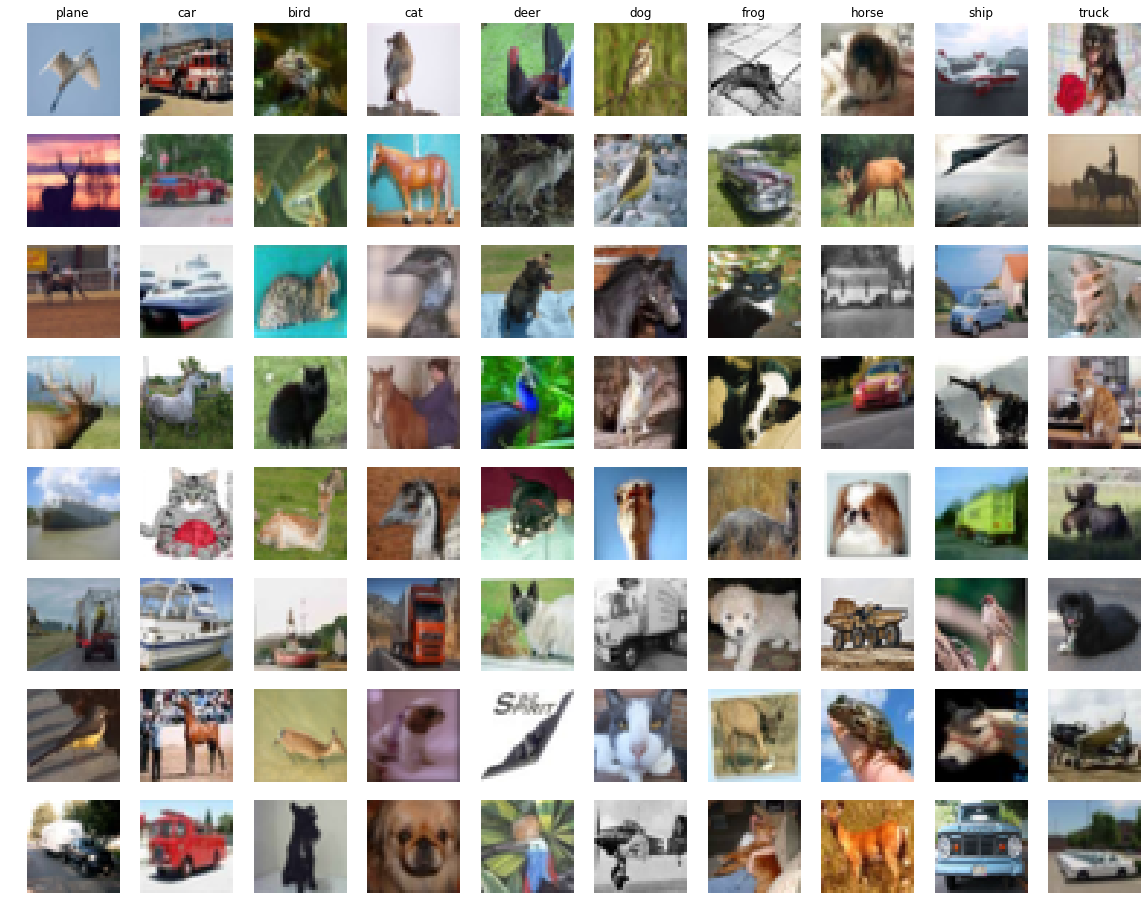

In [33]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
plt.rcParams['figure.figsize'] = (20.0, 16.0)
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Answer: They make sense. For example in plane classification there is a lot of blue and orientation of gradients is similar to planes. This can be generalizaed to other examples too.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [4]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 750
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates=[1e0, 8e-1, 5e-1, 3e-1, 1e-1]
regs=[1e-6, 6e-6, 1e-5, 5e-5, 3e-5, 1e-4, 5e-4, 1e-3, 5e-3]
best_val_acc = -1
best_stats = -1
for learning_rate in learning_rates:
    for reg in regs:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1000, batch_size=400,
                    learning_rate=learning_rate, learning_rate_decay=0.95,
                    reg=reg, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print(f"Learning rate:{learning_rate}, reg: {reg} Validation accuracy:{val_acc} ")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net
            best_stats = stats
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.475160
iteration 200 / 1000: loss 1.268954
iteration 300 / 1000: loss 1.319550
iteration 400 / 1000: loss 1.195328
iteration 500 / 1000: loss 1.033820
iteration 600 / 1000: loss 1.046910
iteration 700 / 1000: loss 1.014859
iteration 800 / 1000: loss 0.824198
iteration 900 / 1000: loss 0.886558
Learning rate:1.0, reg: 1e-06 Validation accuracy:0.58 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.348944
iteration 200 / 1000: loss 1.261360
iteration 300 / 1000: loss 1.290437
iteration 400 / 1000: loss 0.998726
iteration 500 / 1000: loss 1.066818
iteration 600 / 1000: loss 0.992219
iteration 700 / 1000: loss 0.943897
iteration 800 / 1000: loss 1.015262
iteration 900 / 1000: loss 0.926954
Learning rate:1.0, reg: 6e-06 Validation accuracy:0.572 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.390872
iteration 200 / 1000: loss 1.204118
iteration 300 / 1000: loss 1.239622
iteration 400 / 1000: loss 1.

iteration 900 / 1000: loss 1.032881
Learning rate:0.5, reg: 6e-06 Validation accuracy:0.578 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.463090
iteration 200 / 1000: loss 1.356153
iteration 300 / 1000: loss 1.380735
iteration 400 / 1000: loss 1.323656
iteration 500 / 1000: loss 1.104134
iteration 600 / 1000: loss 1.214014
iteration 700 / 1000: loss 1.097974
iteration 800 / 1000: loss 1.075658
iteration 900 / 1000: loss 0.959829
Learning rate:0.5, reg: 1e-05 Validation accuracy:0.598 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.508192
iteration 200 / 1000: loss 1.374541
iteration 300 / 1000: loss 1.307357
iteration 400 / 1000: loss 1.241652
iteration 500 / 1000: loss 1.233710
iteration 600 / 1000: loss 1.181395
iteration 700 / 1000: loss 1.128636
iteration 800 / 1000: loss 1.095717
iteration 900 / 1000: loss 0.999580
Learning rate:0.5, reg: 5e-05 Validation accuracy:0.568 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.497927
iterati

iteration 600 / 1000: loss 1.468259
iteration 700 / 1000: loss 1.380705
iteration 800 / 1000: loss 1.326786
iteration 900 / 1000: loss 1.427028
Learning rate:0.1, reg: 5e-05 Validation accuracy:0.521 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.301196
iteration 200 / 1000: loss 2.145937
iteration 300 / 1000: loss 1.787005
iteration 400 / 1000: loss 1.569561
iteration 500 / 1000: loss 1.515379
iteration 600 / 1000: loss 1.436287
iteration 700 / 1000: loss 1.366074
iteration 800 / 1000: loss 1.375874
iteration 900 / 1000: loss 1.464313
Learning rate:0.1, reg: 3e-05 Validation accuracy:0.512 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302844
iteration 200 / 1000: loss 2.097564
iteration 300 / 1000: loss 1.791974
iteration 400 / 1000: loss 1.627124
iteration 500 / 1000: loss 1.568004
iteration 600 / 1000: loss 1.427807
iteration 700 / 1000: loss 1.325570
iteration 800 / 1000: loss 1.378560
iteration 900 / 1000: loss 1.361723
Learning rate:0.1, reg: 0.

In [31]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.582


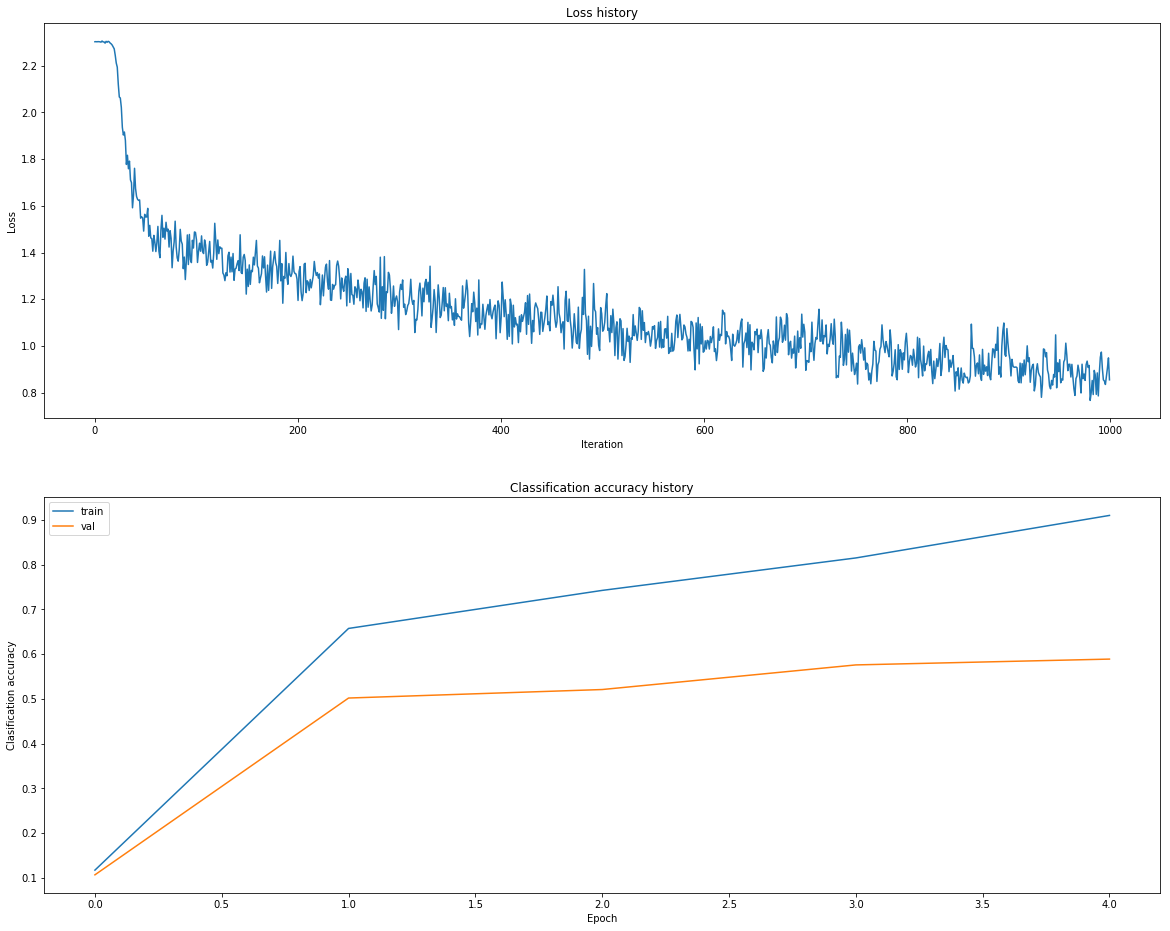

In [32]:
# Plot the loss function and train / validation accuracies
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()